<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/ML-2025a/blob/main/Week_05/Hands_on_coding_Random_Forest_vs_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HOW DECISION TREE SPLITS & VALUES ARE CALCULATED


/tmp/ipython-input-857871412.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


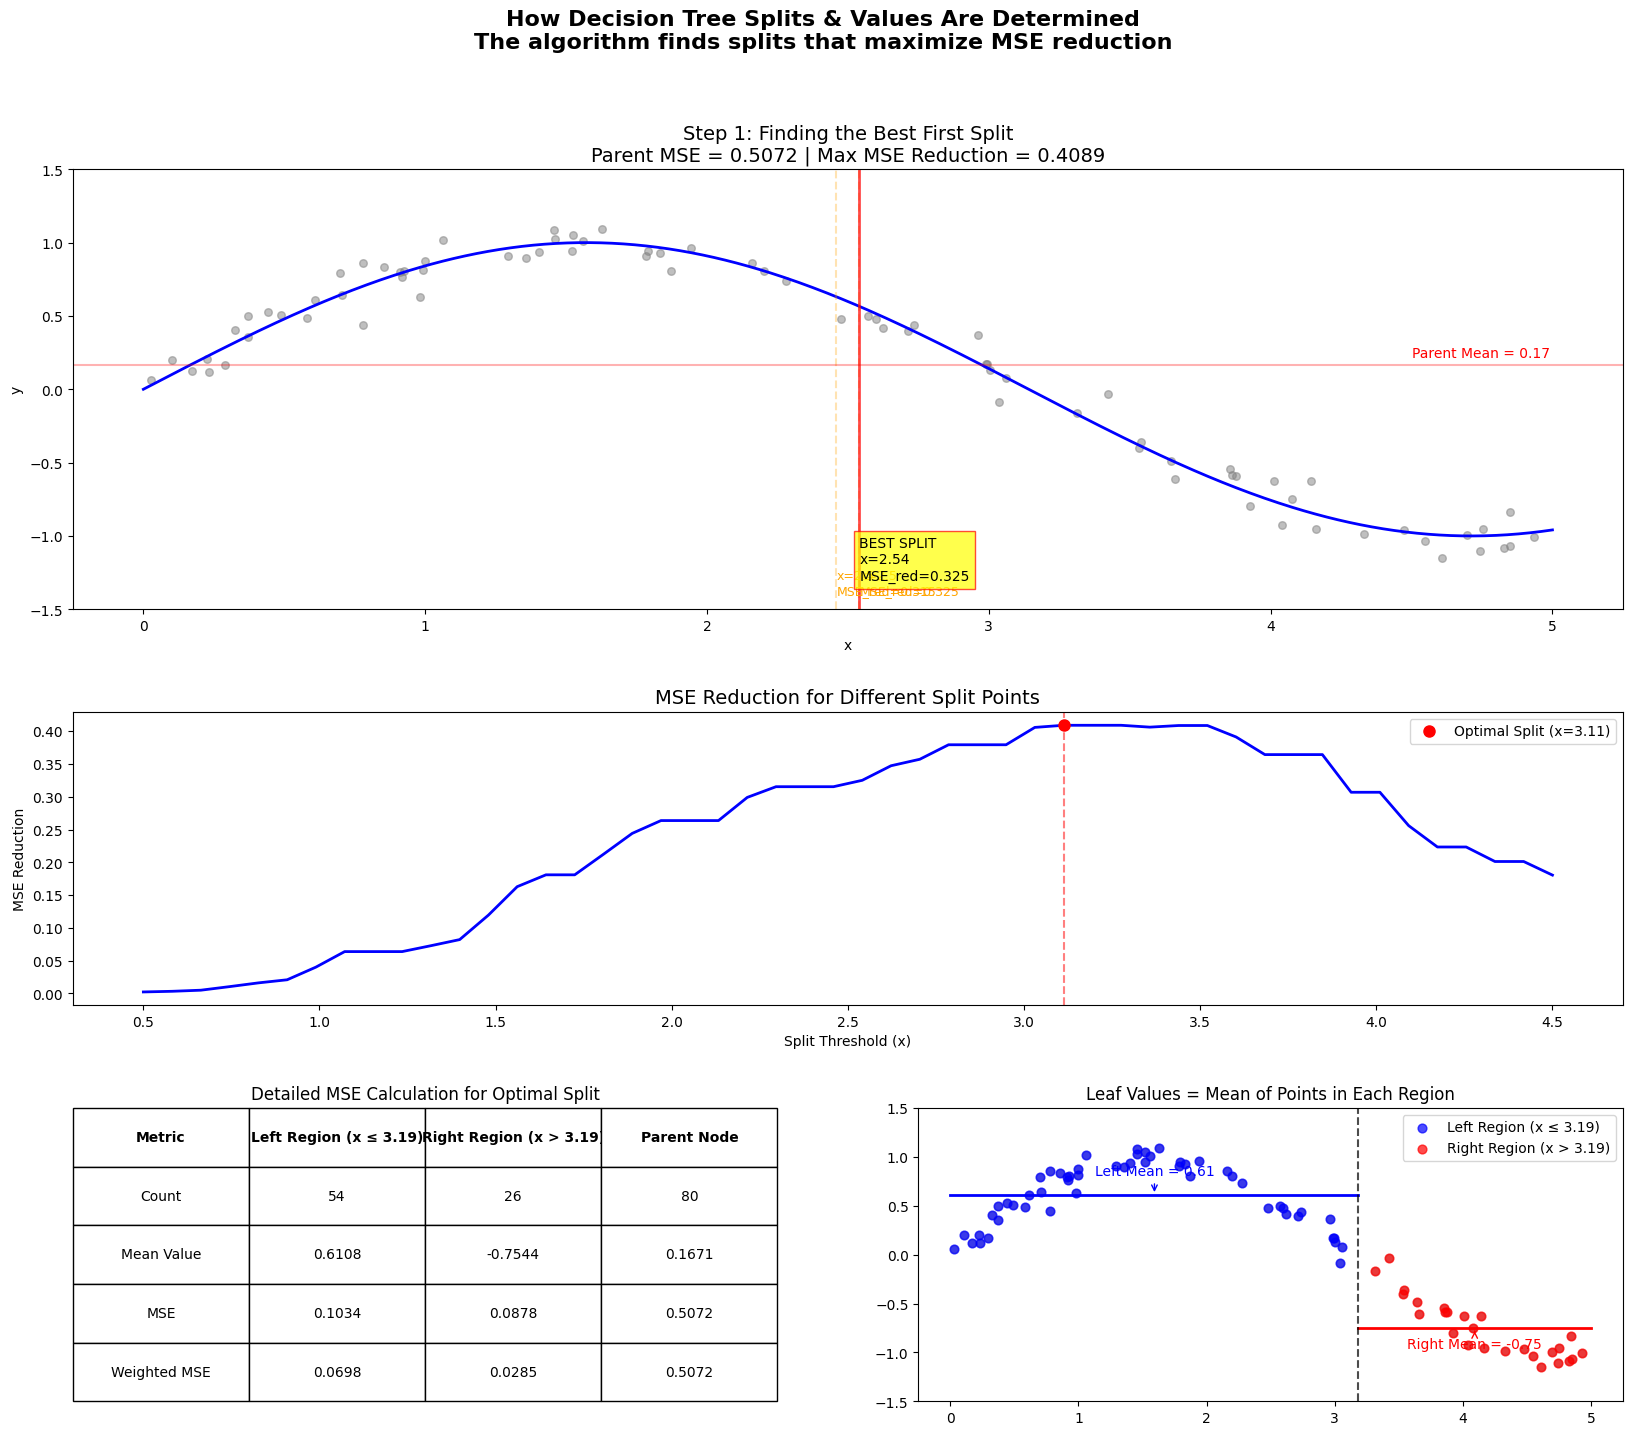


HOW RANDOM FOREST CREATES DIVERSE TREES


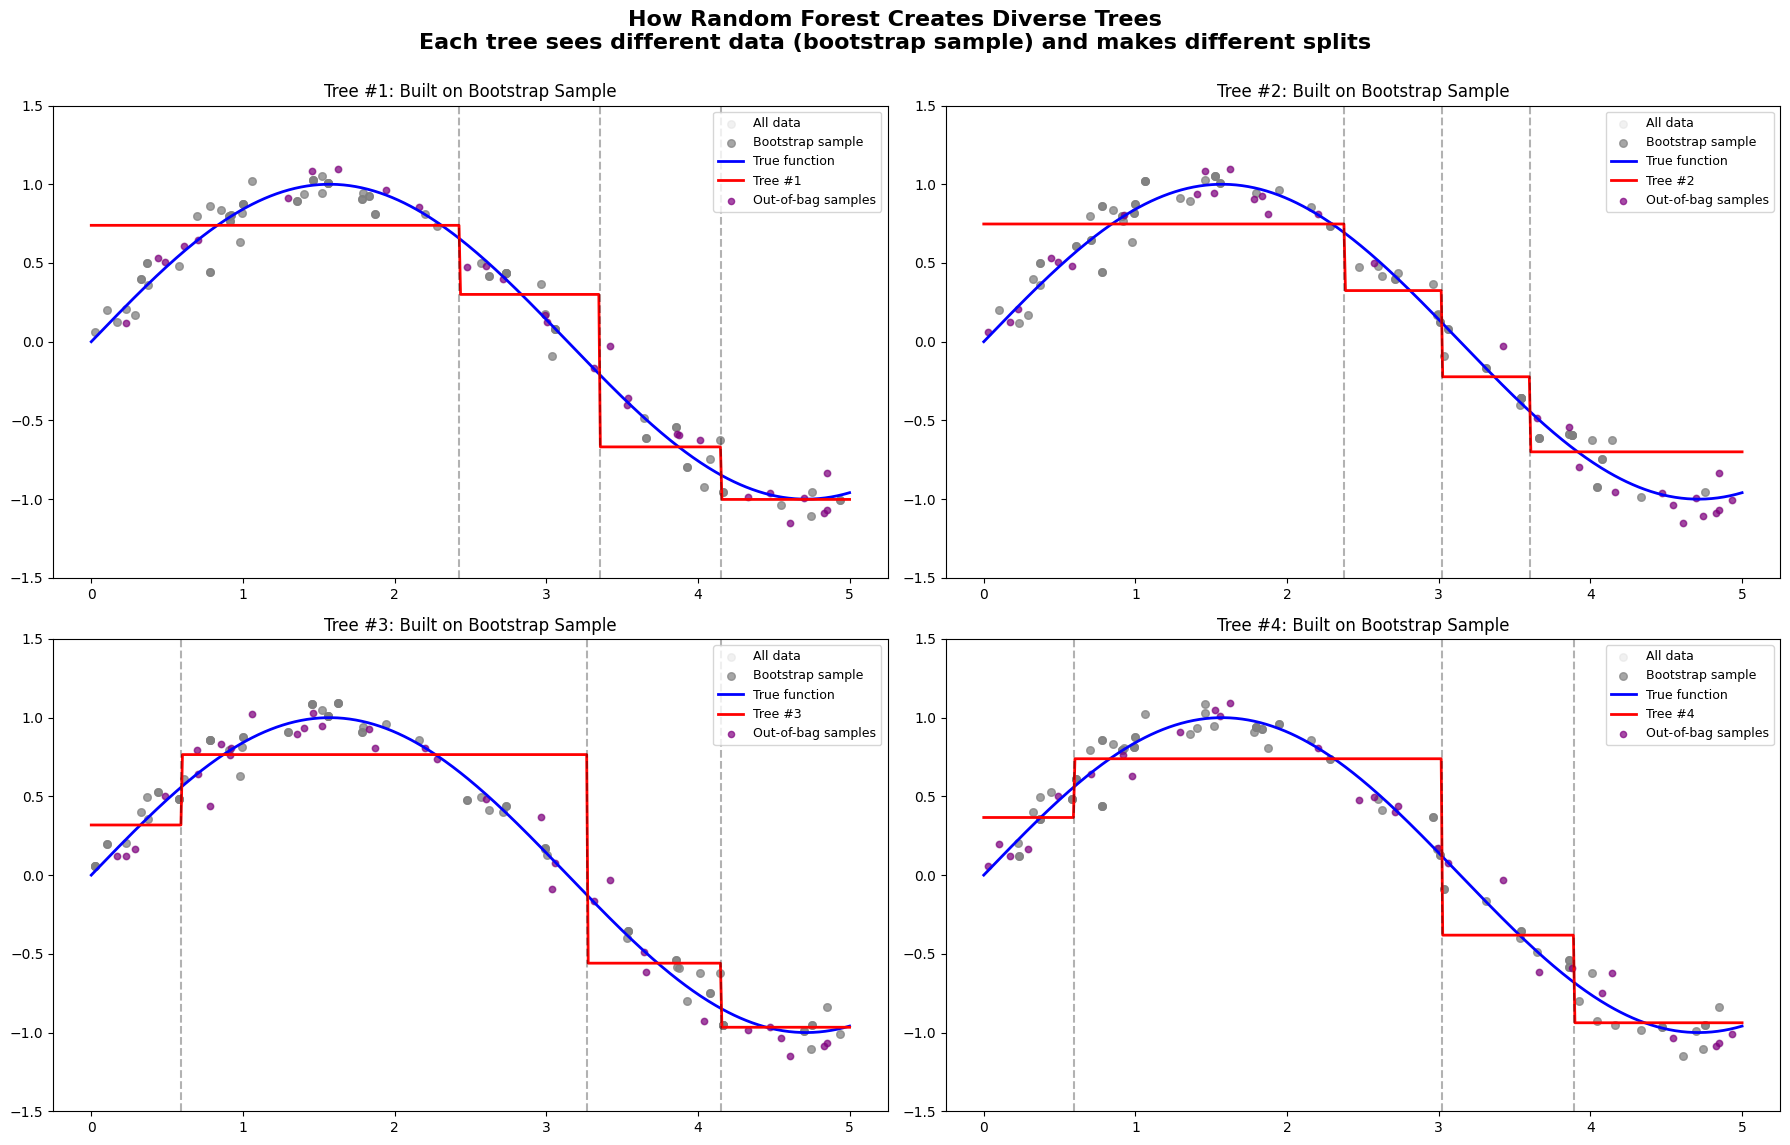

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import matplotlib.gridspec as gridspec
import pandas as pd

# Set up synthetic data (1D regression)
np.random.seed(42)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.randn(80) * 0.1
X_plot = np.linspace(0, 5, 500)[:, np.newaxis]

def visualize_split_selection_process():
    plt.figure(figsize=(20, 16))

    # Create gridspec for layout
    gs = gridspec.GridSpec(3, 2, height_ratios=[1.5, 1, 1], hspace=0.3)

    # ====== STEP 1: SHOW POTENTIAL SPLITS & MSE REDUCTION ======
    ax1 = plt.subplot(gs[0, :])
    ax1.scatter(X, y, color='gray', alpha=0.5, s=30)
    ax1.plot(X_plot, np.sin(X_plot), 'b-', linewidth=2, label='True function')

    # Calculate parent MSE
    parent_mean = np.mean(y)
    parent_mse = np.mean((y - parent_mean) ** 2)

    # Evaluate potential splits
    thresholds = np.linspace(0.5, 4.5, 50)
    mse_reductions = []

    for t in thresholds:
        # Left region
        left_mask = X[:, 0] <= t
        left_y = y[left_mask]
        left_mean = np.mean(left_y) if len(left_y) > 0 else parent_mean
        left_mse = np.mean((left_y - left_mean) ** 2) if len(left_y) > 0 else 0

        # Right region
        right_mask = X[:, 0] > t
        right_y = y[right_mask]
        right_mean = np.mean(right_y) if len(right_y) > 0 else parent_mean
        right_mse = np.mean((right_y - right_mean) ** 2) if len(right_y) > 0 else 0

        # Weighted MSE after split
        n_left = len(left_y)
        n_right = len(right_y)
        n_total = n_left + n_right
        mse_after = (n_left/n_total) * left_mse + (n_right/n_total) * right_mse

        # MSE reduction
        mse_reduction = parent_mse - mse_after
        mse_reductions.append(mse_reduction)

        # Visualize this potential split
        if abs(t - 2.5) < 0.1:  # Highlight a non-optimal split
            ax1.axvline(x=t, color='orange', linestyle='--', alpha=0.3)
            ax1.text(t, -1.4, f'x={t:.1f}\nMSE_red={mse_reduction:.3f}',
                    fontsize=9, color='orange')

        if abs(t - 2.52) < 0.05:  # Highlight the optimal split
            ax1.axvline(x=t, color='red', linestyle='-', alpha=0.7, linewidth=2)
            ax1.text(t, -1.3, f'BEST SPLIT\nx={t:.2f}\nMSE_red={mse_reduction:.3f}',
                    fontsize=10,
                    bbox=dict(facecolor='yellow', alpha=0.7, edgecolor='red'))

    # Mark parent mean
    ax1.axhline(y=parent_mean, color='r', linestyle='-', alpha=0.3)
    ax1.text(4.5, parent_mean+0.05, f'Parent Mean = {parent_mean:.2f}',
            fontsize=10, color='r')

    ax1.set_title(f'Step 1: Finding the Best First Split\n'
                 f'Parent MSE = {parent_mse:.4f} | '
                 f'Max MSE Reduction = {max(mse_reductions):.4f}',
                 fontsize=14)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    # ====== STEP 2: MSE REDUCTION CURVE ======
    ax2 = plt.subplot(gs[1, :])
    ax2.plot(thresholds, mse_reductions, 'b-', linewidth=2)

    # Mark the optimal split
    best_idx = np.argmax(mse_reductions)
    best_threshold = thresholds[best_idx]
    best_reduction = mse_reductions[best_idx]

    ax2.plot(best_threshold, best_reduction, 'ro', markersize=8,
            label=f'Optimal Split (x={best_threshold:.2f})')

    # Add vertical line at optimal split
    ax2.axvline(x=best_threshold, color='r', linestyle='--', alpha=0.5)

    ax2.set_title('MSE Reduction for Different Split Points', fontsize=14)
    ax2.set_xlabel('Split Threshold (x)')
    ax2.set_ylabel('MSE Reduction')
    ax2.legend()

    # ====== STEP 3: DETAILED CALCULATION FOR OPTIMAL SPLIT ======
    # Get the optimal split
    tree = DecisionTreeRegressor(max_depth=1, random_state=42)
    tree.fit(X, y)
    split_threshold = tree.tree_.threshold[0]

    # Calculate values for the optimal split
    left_mask = X[:, 0] <= split_threshold
    left_y = y[left_mask]
    left_mean = np.mean(left_y)
    left_mse = np.mean((left_y - left_mean) ** 2)
    n_left = len(left_y)

    right_mask = X[:, 0] > split_threshold
    right_y = y[right_mask]
    right_mean = np.mean(right_y)
    right_mse = np.mean((right_y - right_mean) ** 2)
    n_right = len(right_y)

    # Create a table of calculations
    data = {
        'Metric': ['Count', 'Mean Value', 'MSE', 'Weighted MSE'],
        'Left Region (x ≤ {:.2f})'.format(split_threshold):
            [n_left, '{:.4f}'.format(left_mean), '{:.4f}'.format(left_mse),
             '{:.4f}'.format((n_left/len(y)) * left_mse)],
        'Right Region (x > {:.2f})'.format(split_threshold):
            [n_right, '{:.4f}'.format(right_mean), '{:.4f}'.format(right_mse),
             '{:.4f}'.format((n_right/len(y)) * right_mse)],
        'Parent Node':
            [len(y), '{:.4f}'.format(parent_mean), '{:.4f}'.format(parent_mse),
             '{:.4f}'.format(parent_mse)]
    }

    df = pd.DataFrame(data)

    # Plot the table
    ax3 = plt.subplot(gs[2, 0])
    ax3.axis('tight')
    ax3.axis('off')
    table = ax3.table(cellText=df.values,
                    colLabels=df.columns,
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])

    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Highlight important values
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header row
            cell.set_text_props(weight='bold')
        if j > 0 and i > 0 and i < 3:  # Numeric values
            try:
                val = float(df.values[i-1, j-1].replace(',', ''))
                if val == best_reduction or (i == 4 and j == 3):
                    cell.set_facecolor('yellow')
            except:
                pass

    ax3.set_title('Detailed MSE Calculation for Optimal Split', fontsize=12)

    # ====== STEP 4: VISUALIZE LEAF VALUE CALCULATION ======
    ax4 = plt.subplot(gs[2, 1])

    # Plot all points
    ax4.scatter(X, y, color='gray', alpha=0.5, s=30)

    # Highlight left region points
    ax4.scatter(X[left_mask], y[left_mask], color='blue', alpha=0.7, s=40,
               label=f'Left Region (x ≤ {split_threshold:.2f})')

    # Highlight right region points
    ax4.scatter(X[right_mask], y[right_mask], color='red', alpha=0.7, s=40,
               label=f'Right Region (x > {split_threshold:.2f})')

    # Plot means as horizontal lines
    ax4.plot([0, split_threshold], [left_mean, left_mean], 'b-', linewidth=2)
    ax4.plot([split_threshold, 5], [right_mean, right_mean], 'r-', linewidth=2)

    # Draw split line
    ax4.axvline(x=split_threshold, color='k', linestyle='--', alpha=0.7)

    # Add annotations for means
    ax4.annotate(f'Left Mean = {left_mean:.2f}',
                xy=(split_threshold/2, left_mean),
                xytext=(split_threshold/2, left_mean+0.2),
                arrowprops=dict(arrowstyle="->", color='blue'),
                ha='center', color='blue')

    ax4.annotate(f'Right Mean = {right_mean:.2f}',
                xy=(split_threshold + (5-split_threshold)/2, right_mean),
                xytext=(split_threshold + (5-split_threshold)/2, right_mean-0.2),
                arrowprops=dict(arrowstyle="->", color='red'),
                ha='center', color='red')

    ax4.set_title('Leaf Values = Mean of Points in Each Region', fontsize=12)
    ax4.set_ylim(-1.5, 1.5)
    ax4.legend(loc='upper right')

    plt.suptitle('How Decision Tree Splits & Values Are Determined\n'
                 'The algorithm finds splits that maximize MSE reduction',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('split_calculation_process.png', dpi=150, bbox_inches='tight')
    plt.show()

# ====== RF DIVERSITY VISUALIZATION ======
def visualize_rf_tree_diversity():
    plt.figure(figsize=(18, 12))

    # Train multiple trees with different bootstrap samples
    trees = []
    for i in range(4):
        # Create bootstrap sample
        indices = np.random.choice(range(len(X)), size=len(X), replace=True)
        X_sample, y_sample = X[indices], y[indices]

        # Train tree on bootstrap sample
        tree = DecisionTreeRegressor(max_depth=2, random_state=i)
        tree.fit(X_sample, y_sample)
        trees.append((tree, indices))

    # Plot each tree's structure
    for i, (tree, indices) in enumerate(trees):
        ax = plt.subplot(2, 2, i+1)

        # Plot all data points
        ax.scatter(X, y, color='lightgray', alpha=0.3, s=30, label='All data')

        # Highlight bootstrap sample
        ax.scatter(X[indices], y[indices], color='gray', alpha=0.7, s=30,
                  label='Bootstrap sample')

        # Plot true function
        ax.plot(X_plot, np.sin(X_plot), 'b-', linewidth=2, label='True function')

        # Plot tree predictions
        pred = tree.predict(X_plot)
        ax.plot(X_plot, pred, 'r-', linewidth=2, label=f'Tree #{i+1}')

        # Show split points
        n_nodes = tree.tree_.node_count
        children_left = tree.tree_.children_left
        children_right = tree.tree_.children_right
        feature = tree.tree_.feature
        threshold = tree.tree_.threshold

        # Get all split points (except leaves)
        split_points = []
        stack = [0]  # Start with root node
        while len(stack) > 0:
            node_id = stack.pop()
            if children_left[node_id] != children_right[node_id]:  # Not a leaf
                split_points.append(threshold[node_id])
                stack.append(children_left[node_id])
                stack.append(children_right[node_id])

        # Plot vertical lines at split points
        for split in split_points:
            ax.axvline(x=split, color='k', linestyle='--', alpha=0.3)

        # Show out-of-bag samples
        oob_mask = np.ones(len(X), dtype=bool)
        oob_mask[indices] = False
        ax.scatter(X[oob_mask], y[oob_mask], color='purple', s=20, alpha=0.7,
                  label='Out-of-bag samples')

        ax.set_title(f'Tree #{i+1}: Built on Bootstrap Sample', fontsize=12)
        ax.set_ylim(-1.5, 1.5)
        ax.legend(loc='upper right', fontsize=9)

    plt.suptitle('How Random Forest Creates Diverse Trees\n'
                 'Each tree sees different data (bootstrap sample) and makes different splits',
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('rf_tree_diversity.png', dpi=150, bbox_inches='tight')
    plt.show()

# Run visualizations
print("="*60)
print("HOW DECISION TREE SPLITS & VALUES ARE CALCULATED")
print("="*60)
visualize_split_selection_process()

print("\n" + "="*60)
print("HOW RANDOM FOREST CREATES DIVERSE TREES")
print("="*60)
visualize_rf_tree_diversity()

HOW A DECISION TREE ARCHITECTURE EVOLVES DURING CONSTRUCTION


/tmp/ipython-input-2482979956.py:254: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


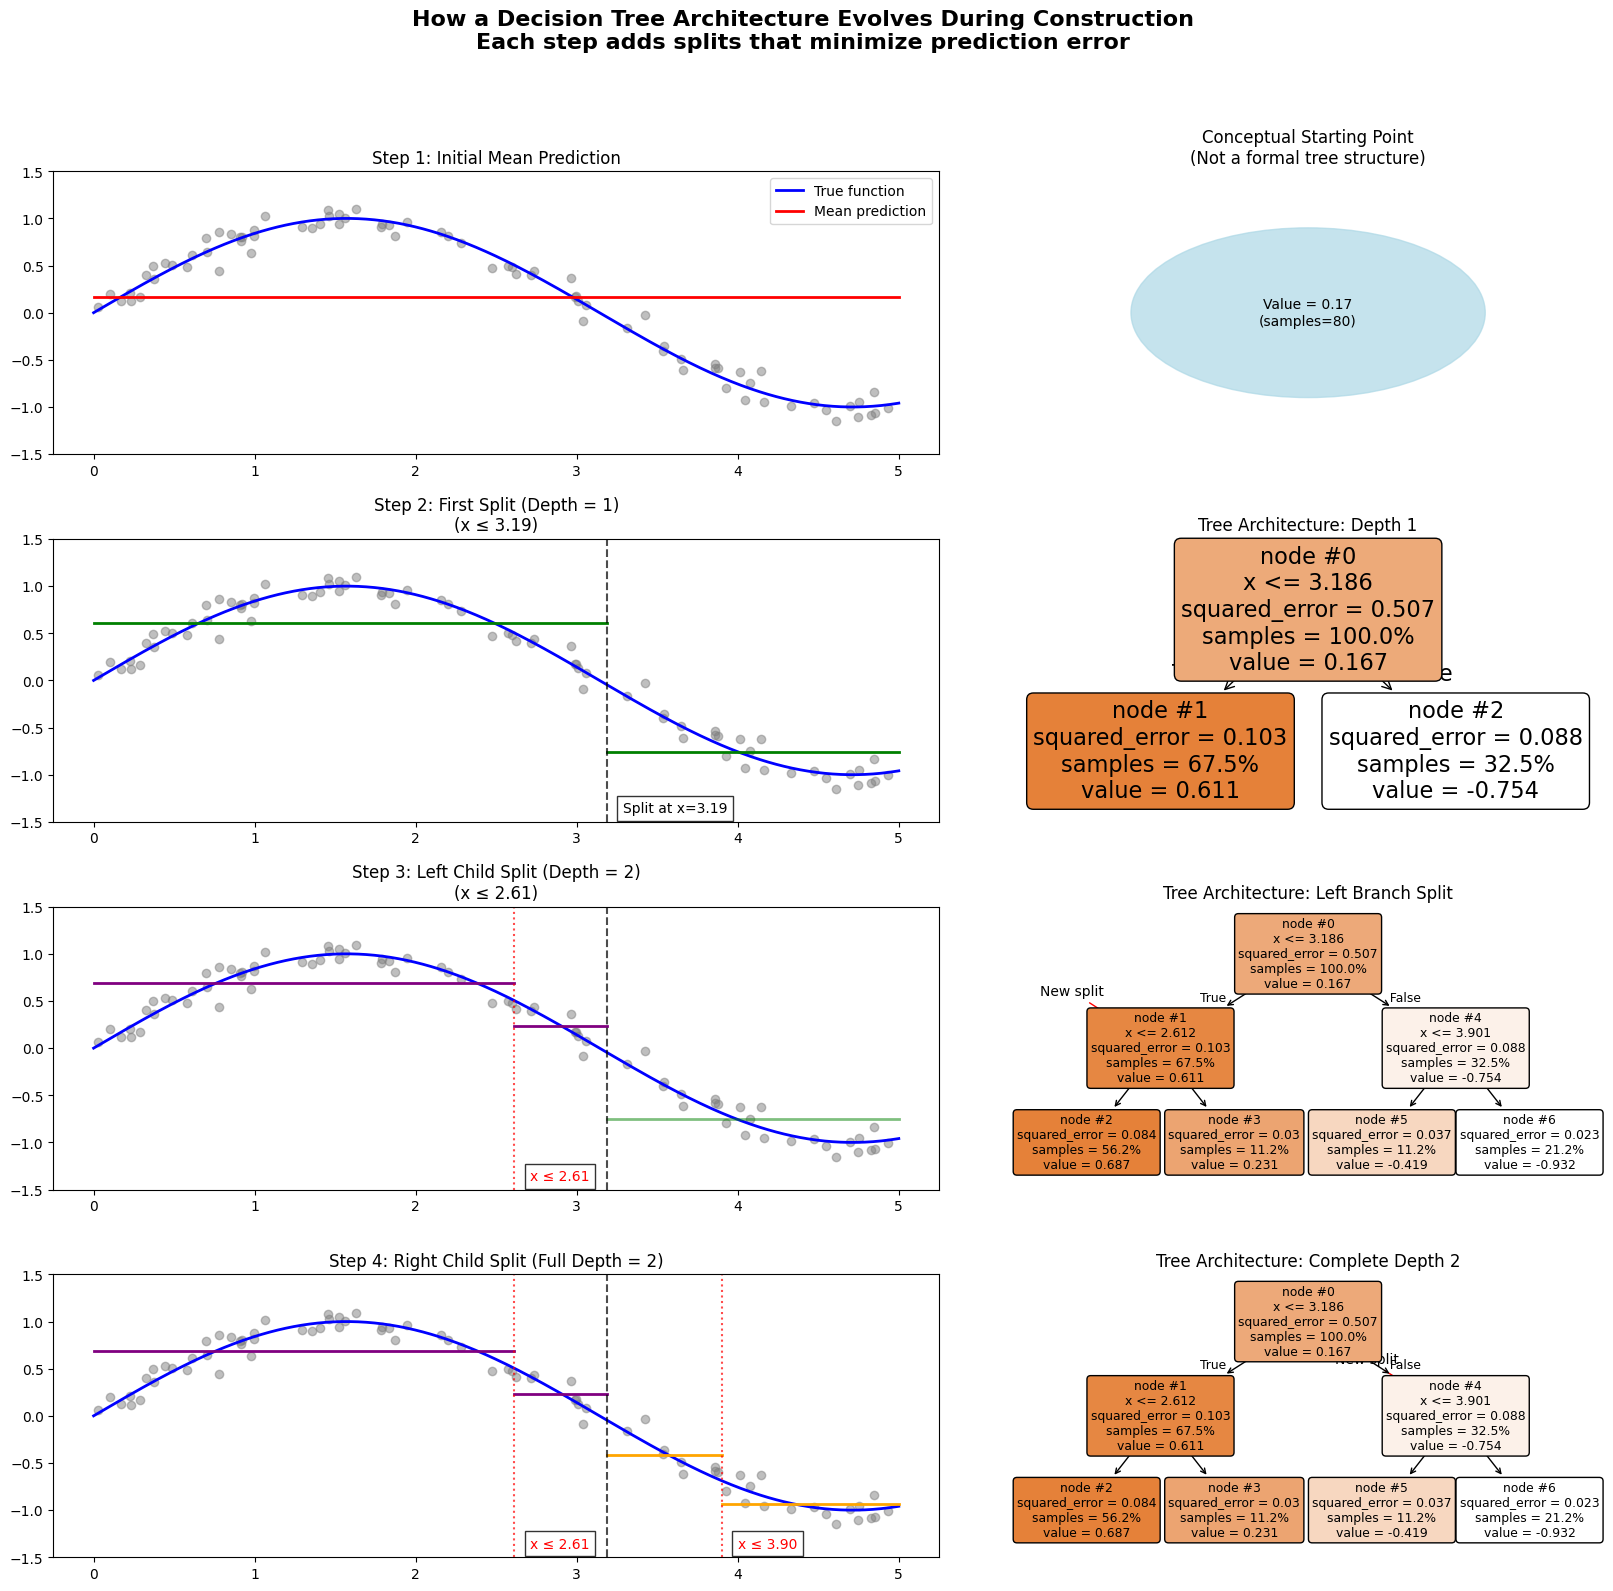


HOW RANDOM FOREST CREATES DIVERSE TREES


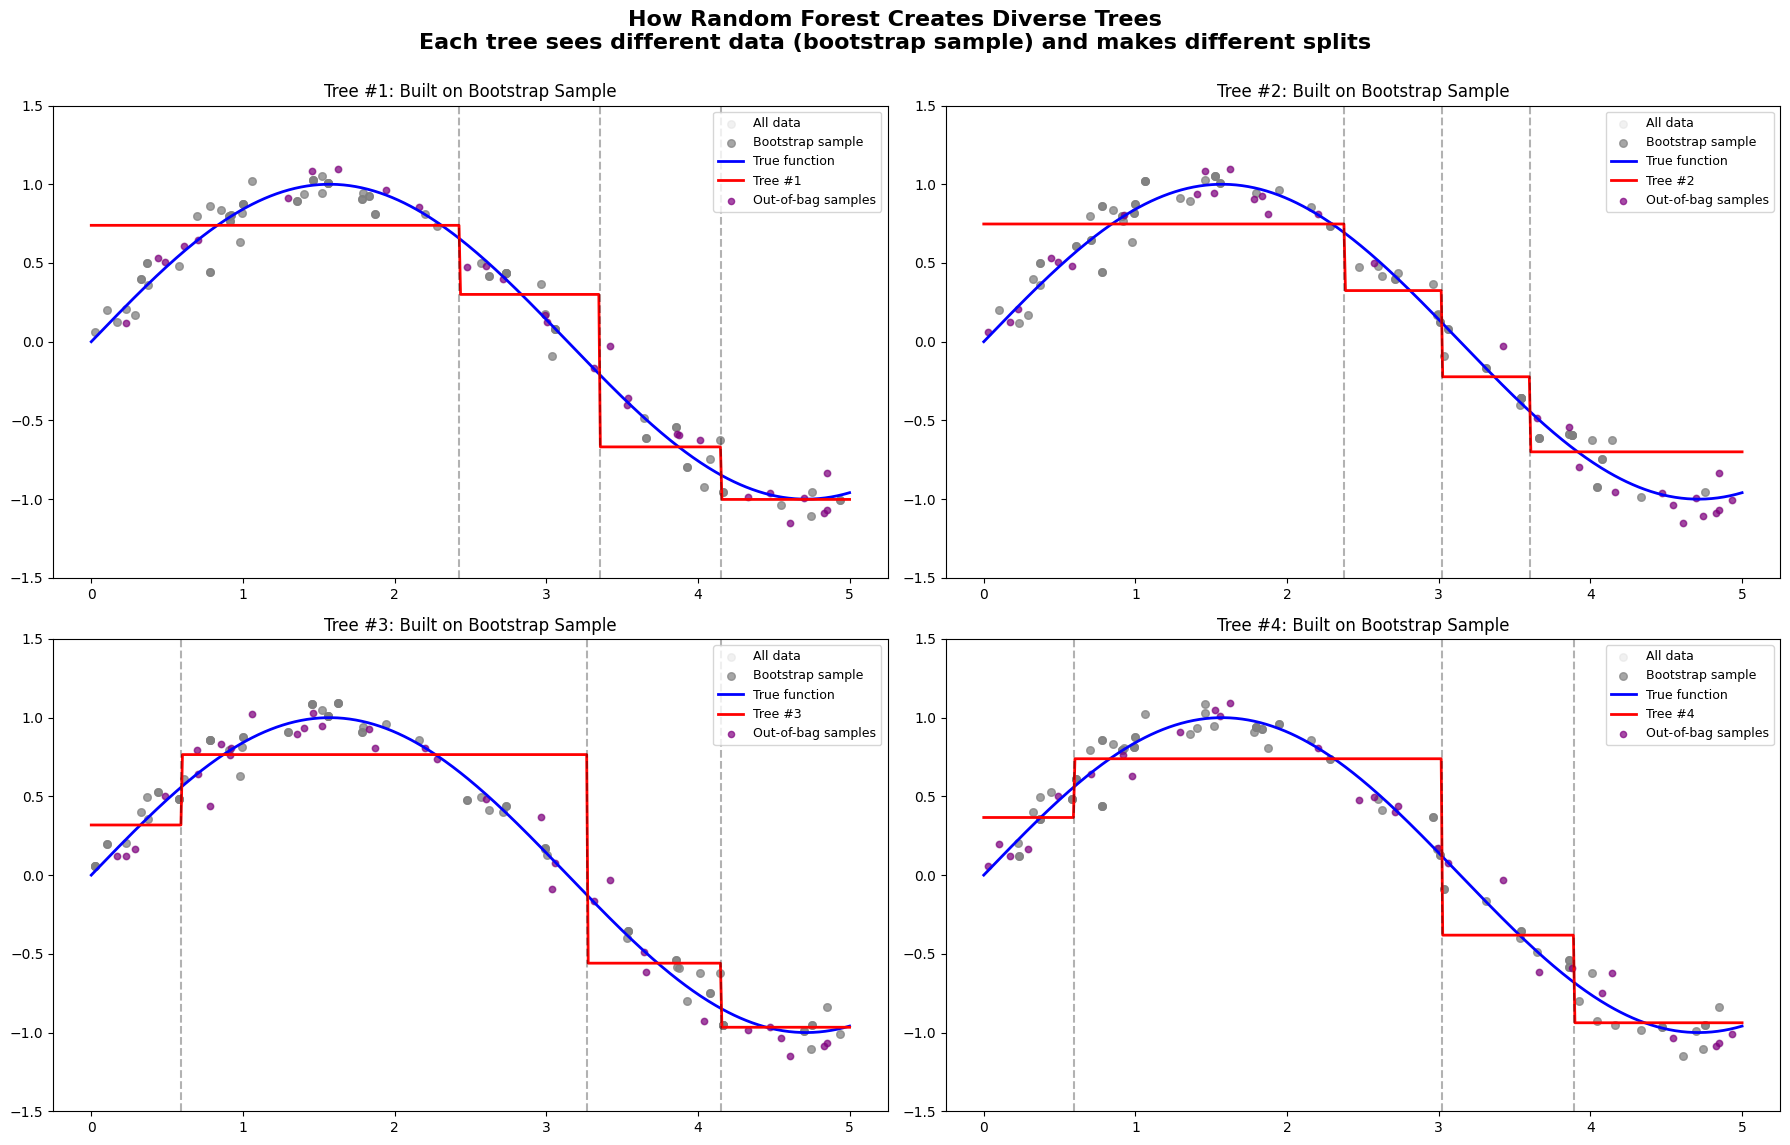

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.gridspec as gridspec
from sklearn.utils import resample
import matplotlib.patches as mpatches

# Set up synthetic data (1D regression)
np.random.seed(42)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.randn(80) * 0.1
X_plot = np.linspace(0, 5, 500)[:, np.newaxis]

def visualize_tree_architecture_evolution():
    plt.figure(figsize=(20, 18))

    # Create gridspec for better layout control (4 rows, 2 columns)
    gs = gridspec.GridSpec(4, 2, width_ratios=[1.5, 1], height_ratios=[1, 1, 1, 1],
                          wspace=0.1, hspace=0.3)

    # ====== STEP 1: INITIAL MEAN PREDICTION (NOT A TREE YET) ======
    # This represents the conceptual starting point before any splits
    mean_val = np.mean(y)

    # Prediction plot
    ax1_pred = plt.subplot(gs[0, 0])
    ax1_pred.scatter(X, y, color='gray', alpha=0.5)
    ax1_pred.plot(X_plot, np.sin(X_plot), 'b-', linewidth=2, label='True function')

    # Mean prediction
    mean_pred = np.full_like(X_plot, mean_val)
    ax1_pred.plot(X_plot, mean_pred, 'r-', linewidth=2, label='Mean prediction')

    ax1_pred.set_title('Step 1: Initial Mean Prediction', fontsize=12)
    ax1_pred.set_ylim(-1.5, 1.5)
    ax1_pred.legend(loc='upper right')

    # Tree structure visualization (manually created since scikit-learn doesn't support depth=0)
    ax1_tree = plt.subplot(gs[0, 1])

    # Draw a single node (root only)
    circle = plt.Circle((0.5, 0.5), 0.3, fill=True, color='lightblue', alpha=0.7)
    ax1_tree.add_patch(circle)

    # Add text to the node
    ax1_tree.text(0.5, 0.5, f'Value = {mean_val:.2f}\n(samples={len(y)})',
                 ha='center', va='center', fontsize=10)

    ax1_tree.set_xlim(0, 1)
    ax1_tree.set_ylim(0, 1)
    ax1_tree.axis('off')
    ax1_tree.set_title('Conceptual Starting Point\n(Not a formal tree structure)', fontsize=12)

    # ====== STEP 2: FIRST SPLIT (DEPTH 1) ======
    # Train tree with max_depth=1
    tree_depth1 = DecisionTreeRegressor(max_depth=1, random_state=42)
    tree_depth1.fit(X, y)

    # Get split information
    split_feature = tree_depth1.tree_.feature[0]
    split_threshold = tree_depth1.tree_.threshold[0]
    left_pred = tree_depth1.tree_.value[1][0][0]
    right_pred = tree_depth1.tree_.value[2][0][0]
    n_left = (X <= split_threshold).sum()
    n_right = len(X) - n_left

    # Prediction plot
    ax2_pred = plt.subplot(gs[1, 0])
    ax2_pred.scatter(X, y, color='gray', alpha=0.5)
    ax2_pred.plot(X_plot, np.sin(X_plot), 'b-', linewidth=2, label='True function')

    # Left region prediction
    ax2_pred.plot([0, split_threshold], [left_pred, left_pred], 'g-', linewidth=2)

    # Right region prediction
    ax2_pred.plot([split_threshold, 5], [right_pred, right_pred], 'g-', linewidth=2)

    # Draw split line
    ax2_pred.axvline(x=split_threshold, color='k', linestyle='--', alpha=0.7)
    ax2_pred.text(split_threshold+0.1, -1.4, f'Split at x={split_threshold:.2f}',
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    ax2_pred.set_title(f'Step 2: First Split (Depth = 1)\n(x ≤ {split_threshold:.2f})', fontsize=12)
    ax2_pred.set_ylim(-1.5, 1.5)

    # Tree structure
    ax2_tree = plt.subplot(gs[1, 1])
    plot_tree(tree_depth1,
             feature_names=['x'],
             filled=True,
             rounded=True,
             proportion=True,
             node_ids=True,
             ax=ax2_tree)
    ax2_tree.set_title('Tree Architecture: Depth 1', fontsize=12)

    # Add annotations to tree
    ax2_tree.annotate(f'x ≤ {split_threshold:.2f}',
                     xy=(0.5, 0.8), xycoords='axes fraction',
                     ha='center', va='center', fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="black", alpha=0.7))

    ax2_tree.annotate(f'Value = {left_pred:.2f}\n(n={n_left})',
                     xy=(0.25, 0.2), xycoords='axes fraction',
                     ha='center', va='center', fontsize=9)

    ax2_tree.annotate(f'Value = {right_pred:.2f}\n(n={n_right})',
                     xy=(0.75, 0.2), xycoords='axes fraction',
                     ha='center', va='center', fontsize=9)

    # ====== STEP 3: LEFT CHILD SPLIT (DEPTH 2, PARTIAL) ======
    # Train tree with max_depth=2
    tree_depth2 = DecisionTreeRegressor(max_depth=2, random_state=42)
    tree_depth2.fit(X, y)

    # Root split
    root_split = tree_depth2.tree_.threshold[0]

    # Left child split
    left_node = tree_depth2.tree_.children_left[0]
    left_split = tree_depth2.tree_.threshold[left_node]
    left_left_pred = tree_depth2.tree_.value[tree_depth2.tree_.children_left[left_node]][0][0]
    left_right_pred = tree_depth2.tree_.value[tree_depth2.tree_.children_right[left_node]][0][0]
    n_left_left = (X[X <= root_split] <= left_split).sum()
    n_left_right = (X[X <= root_split] > left_split).sum()

    ax3_pred = plt.subplot(gs[2, 0])
    ax3_pred.scatter(X, y, color='gray', alpha=0.5)
    ax3_pred.plot(X_plot, np.sin(X_plot), 'b-', linewidth=2, label='True function')

    # Left-left region
    ax3_pred.plot([0, left_split], [left_left_pred, left_left_pred], 'purple', linewidth=2)

    # Left-right region
    ax3_pred.plot([left_split, root_split], [left_right_pred, left_right_pred], 'purple', linewidth=2)

    # Right region (unchanged from depth 1)
    right_pred = tree_depth2.tree_.value[tree_depth2.tree_.children_right[0]][0][0]
    n_right = len(X) - (X <= root_split).sum()
    ax3_pred.plot([root_split, 5], [right_pred, right_pred], 'g-', linewidth=2, alpha=0.5)

    # Draw splits
    ax3_pred.axvline(x=root_split, color='k', linestyle='--', alpha=0.7)
    ax3_pred.axvline(x=left_split, color='r', linestyle=':', alpha=0.7)
    ax3_pred.text(left_split+0.1, -1.4, f'x ≤ {left_split:.2f}',
                 fontsize=10, color='r', bbox=dict(facecolor='white', alpha=0.8))

    ax3_pred.set_title(f'Step 3: Left Child Split (Depth = 2)\n(x ≤ {left_split:.2f})', fontsize=12)
    ax3_pred.set_ylim(-1.5, 1.5)

    # Tree structure
    ax3_tree = plt.subplot(gs[2, 1])
    plot_tree(tree_depth2,
             feature_names=['x'],
             filled=True,
             rounded=True,
             proportion=True,
             node_ids=True,
             ax=ax3_tree)
    ax3_tree.set_title('Tree Architecture: Left Branch Split', fontsize=12)

    # Highlight the new split in the tree
    ax3_tree.annotate("New split",
                     xy=(0.25, 0.5), xycoords='axes fraction',
                     xytext=(0.1, 0.7), textcoords='axes fraction',
                     arrowprops=dict(arrowstyle="->", color='red'),
                     ha='center', va='center', fontsize=10)

    # Add node annotations for the new split
    ax3_tree.annotate(f'x ≤ {left_split:.2f}',
                     xy=(0.25, 0.5), xycoords='axes fraction',
                     ha='center', va='center', fontsize=9)

    ax3_tree.annotate(f'Value = {left_left_pred:.2f}\n(n={n_left_left})',
                     xy=(0.125, 0.1), xycoords='axes fraction',
                     ha='center', va='center', fontsize=8)

    ax3_tree.annotate(f'Value = {left_right_pred:.2f}\n(n={n_left_right})',
                     xy=(0.375, 0.1), xycoords='axes fraction',
                     ha='center', va='center', fontsize=8)

    # ====== STEP 4: RIGHT CHILD SPLIT (FULL DEPTH 2) ======
    # Get right child split
    right_node = tree_depth2.tree_.children_right[0]
    right_split = tree_depth2.tree_.threshold[right_node]
    right_left_pred = tree_depth2.tree_.value[tree_depth2.tree_.children_left[right_node]][0][0]
    right_right_pred = tree_depth2.tree_.value[tree_depth2.tree_.children_right[right_node]][0][0]
    n_right_left = (X[X > root_split] <= right_split).sum()
    n_right_right = (X[X > root_split] > right_split).sum()

    ax4_pred = plt.subplot(gs[3, 0])
    ax4_pred.scatter(X, y, color='gray', alpha=0.5)
    ax4_pred.plot(X_plot, np.sin(X_plot), 'b-', linewidth=2, label='True function')

    # Left-left region
    ax4_pred.plot([0, left_split], [left_left_pred, left_left_pred], 'purple', linewidth=2)

    # Left-right region
    ax4_pred.plot([left_split, root_split], [left_right_pred, left_right_pred], 'purple', linewidth=2)

    # Right-left region
    ax4_pred.plot([root_split, right_split], [right_left_pred, right_left_pred], 'orange', linewidth=2)

    # Right-right region
    ax4_pred.plot([right_split, 5], [right_right_pred, right_right_pred], 'orange', linewidth=2)

    # Draw splits
    ax4_pred.axvline(x=root_split, color='k', linestyle='--', alpha=0.7)
    ax4_pred.axvline(x=left_split, color='r', linestyle=':', alpha=0.7)
    ax4_pred.axvline(x=right_split, color='r', linestyle=':', alpha=0.7)

    ax4_pred.text(left_split+0.1, -1.4, f'x ≤ {left_split:.2f}',
                 fontsize=10, color='r', bbox=dict(facecolor='white', alpha=0.8))
    ax4_pred.text(right_split+0.1, -1.4, f'x ≤ {right_split:.2f}',
                 fontsize=10, color='r', bbox=dict(facecolor='white', alpha=0.8))

    ax4_pred.set_title(f'Step 4: Right Child Split (Full Depth = 2)', fontsize=12)
    ax4_pred.set_ylim(-1.5, 1.5)

    # Final tree structure
    ax4_tree = plt.subplot(gs[3, 1])
    plot_tree(tree_depth2,
             feature_names=['x'],
             filled=True,
             rounded=True,
             proportion=True,
             node_ids=True,
             ax=ax4_tree)
    ax4_tree.set_title('Tree Architecture: Complete Depth 2', fontsize=12)

    # Highlight the final split
    ax4_tree.annotate("New split",
                     xy=(0.75, 0.5), xycoords='axes fraction',
                     xytext=(0.6, 0.7), textcoords='axes fraction',
                     arrowprops=dict(arrowstyle="->", color='red'),
                     ha='center', va='center', fontsize=10)

    # Add node annotations for the right split
    ax4_tree.annotate(f'x ≤ {right_split:.2f}',
                     xy=(0.75, 0.5), xycoords='axes fraction',
                     ha='center', va='center', fontsize=9)

    ax4_tree.annotate(f'Value = {right_left_pred:.2f}\n(n={n_right_left})',
                     xy=(0.625, 0.1), xycoords='axes fraction',
                     ha='center', va='center', fontsize=8)

    ax4_tree.annotate(f'Value = {right_right_pred:.2f}\n(n={n_right_right})',
                     xy=(0.875, 0.1), xycoords='axes fraction',
                     ha='center', va='center', fontsize=8)

    plt.suptitle('How a Decision Tree Architecture Evolves During Construction\n'
                 'Each step adds splits that minimize prediction error',
                 fontsize=16, fontweight='bold', y=0.97)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('tree_architecture_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()

# ====== RF DIVERSITY VISUALIZATION ======
def visualize_rf_tree_diversity():
    plt.figure(figsize=(18, 12))

    # Train multiple trees with different bootstrap samples
    trees = []
    for i in range(4):
        # Create bootstrap sample
        indices = np.random.choice(range(len(X)), size=len(X), replace=True)
        X_sample, y_sample = X[indices], y[indices]

        # Train tree on bootstrap sample
        tree = DecisionTreeRegressor(max_depth=2, random_state=i)
        tree.fit(X_sample, y_sample)
        trees.append((tree, indices))

    # Plot each tree's structure
    for i, (tree, indices) in enumerate(trees):
        ax = plt.subplot(2, 2, i+1)

        # Plot all data points
        ax.scatter(X, y, color='lightgray', alpha=0.3, s=30, label='All data')

        # Highlight bootstrap sample
        ax.scatter(X[indices], y[indices], color='gray', alpha=0.7, s=30,
                  label='Bootstrap sample')

        # Plot true function
        ax.plot(X_plot, np.sin(X_plot), 'b-', linewidth=2, label='True function')

        # Plot tree predictions
        pred = tree.predict(X_plot)
        ax.plot(X_plot, pred, 'r-', linewidth=2, label=f'Tree #{i+1}')

        # Show split points
        n_nodes = tree.tree_.node_count
        children_left = tree.tree_.children_left
        children_right = tree.tree_.children_right
        feature = tree.tree_.feature
        threshold = tree.tree_.threshold

        # Get all split points (except leaves)
        split_points = []
        stack = [0]  # Start with root node
        while len(stack) > 0:
            node_id = stack.pop()
            if children_left[node_id] != children_right[node_id]:  # Not a leaf
                split_points.append(threshold[node_id])
                stack.append(children_left[node_id])
                stack.append(children_right[node_id])

        # Plot vertical lines at split points
        for split in split_points:
            ax.axvline(x=split, color='k', linestyle='--', alpha=0.3)

        # Show out-of-bag samples
        oob_mask = np.ones(len(X), dtype=bool)
        oob_mask[indices] = False
        ax.scatter(X[oob_mask], y[oob_mask], color='purple', s=20, alpha=0.7,
                  label='Out-of-bag samples')

        ax.set_title(f'Tree #{i+1}: Built on Bootstrap Sample', fontsize=12)
        ax.set_ylim(-1.5, 1.5)
        ax.legend(loc='upper right', fontsize=9)

    plt.suptitle('How Random Forest Creates Diverse Trees\n'
                 'Each tree sees different data (bootstrap sample) and makes different splits',
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('rf_tree_diversity.png', dpi=150, bbox_inches='tight')
    plt.show()

# Run visualizations
print("="*60)
print("HOW A DECISION TREE ARCHITECTURE EVOLVES DURING CONSTRUCTION")
print("="*60)
visualize_tree_architecture_evolution()

print("\n" + "="*60)
print("HOW RANDOM FOREST CREATES DIVERSE TREES")
print("="*60)
visualize_rf_tree_diversity()

RANDOM FOREST: Trees grow INDEPENDENTLY (first tree never changes)


/tmp/ipython-input-255894085.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


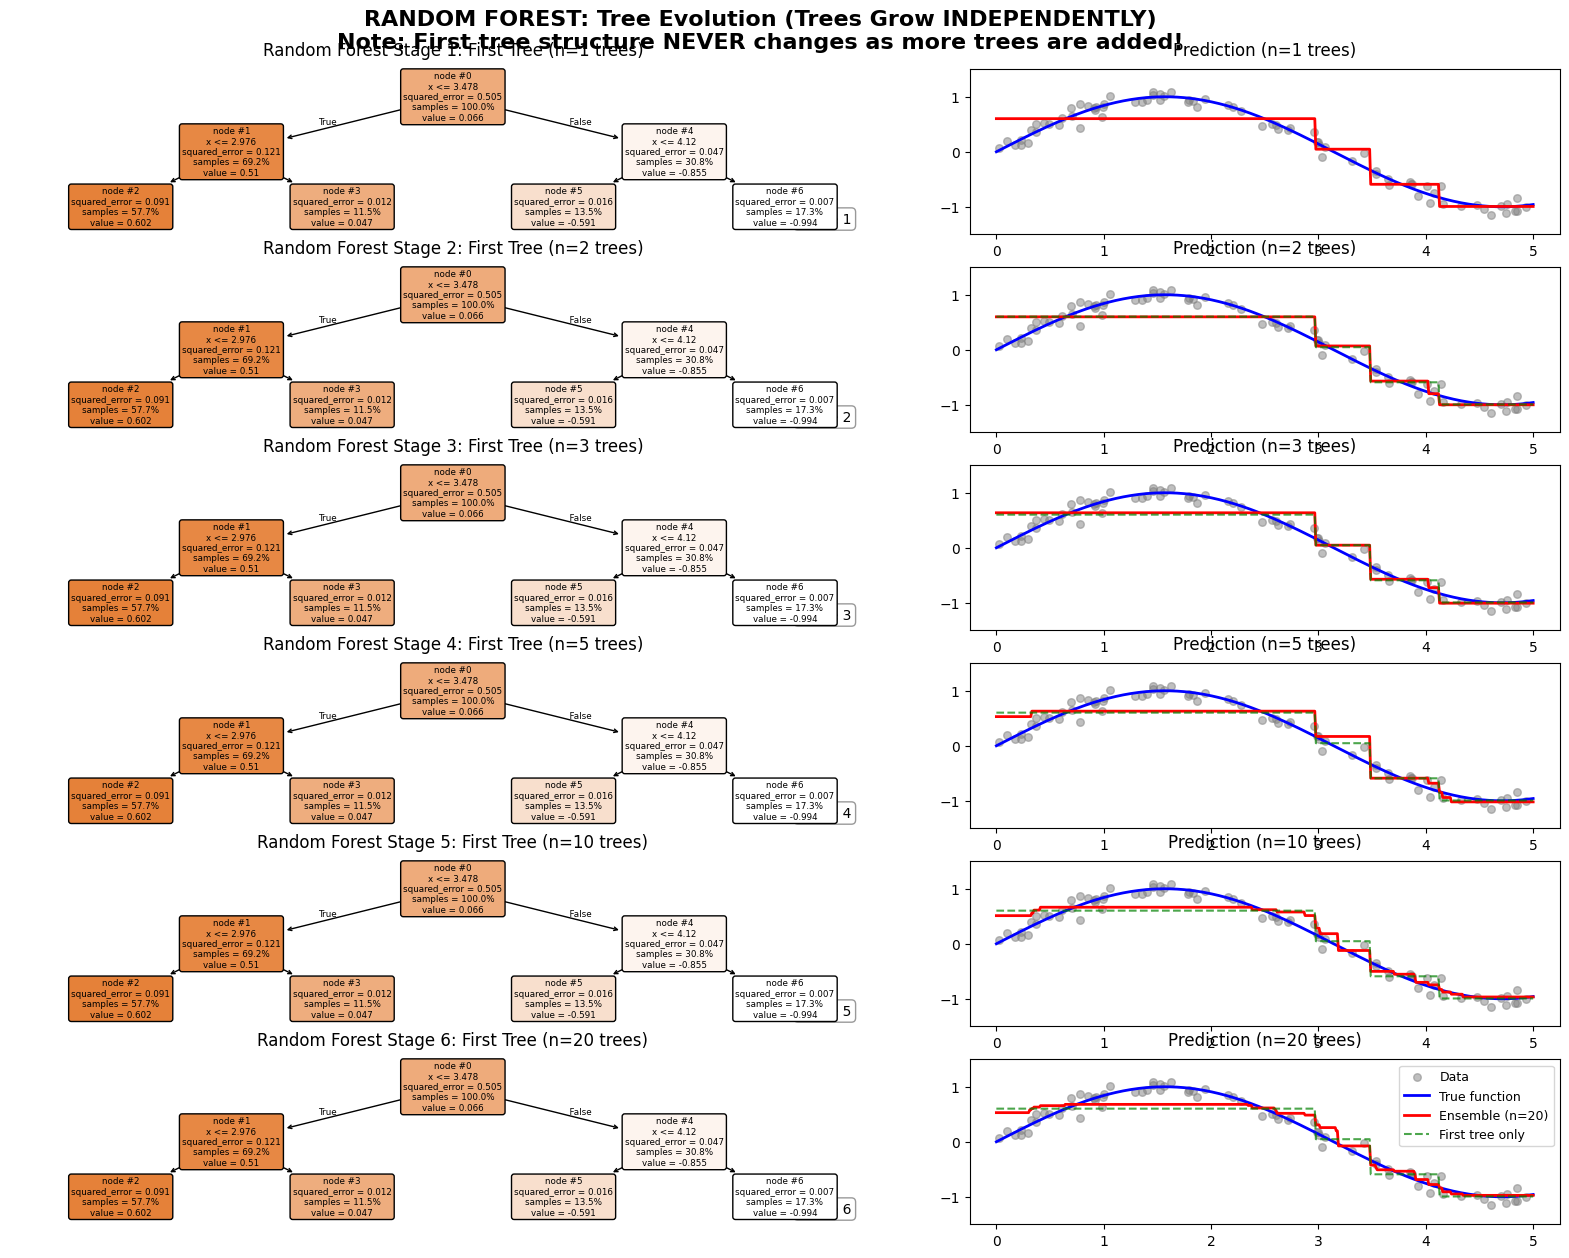


GRADIENT BOOSTING: Trees grow SEQUENTIALLY (each fixes previous errors)


/tmp/ipython-input-255894085.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


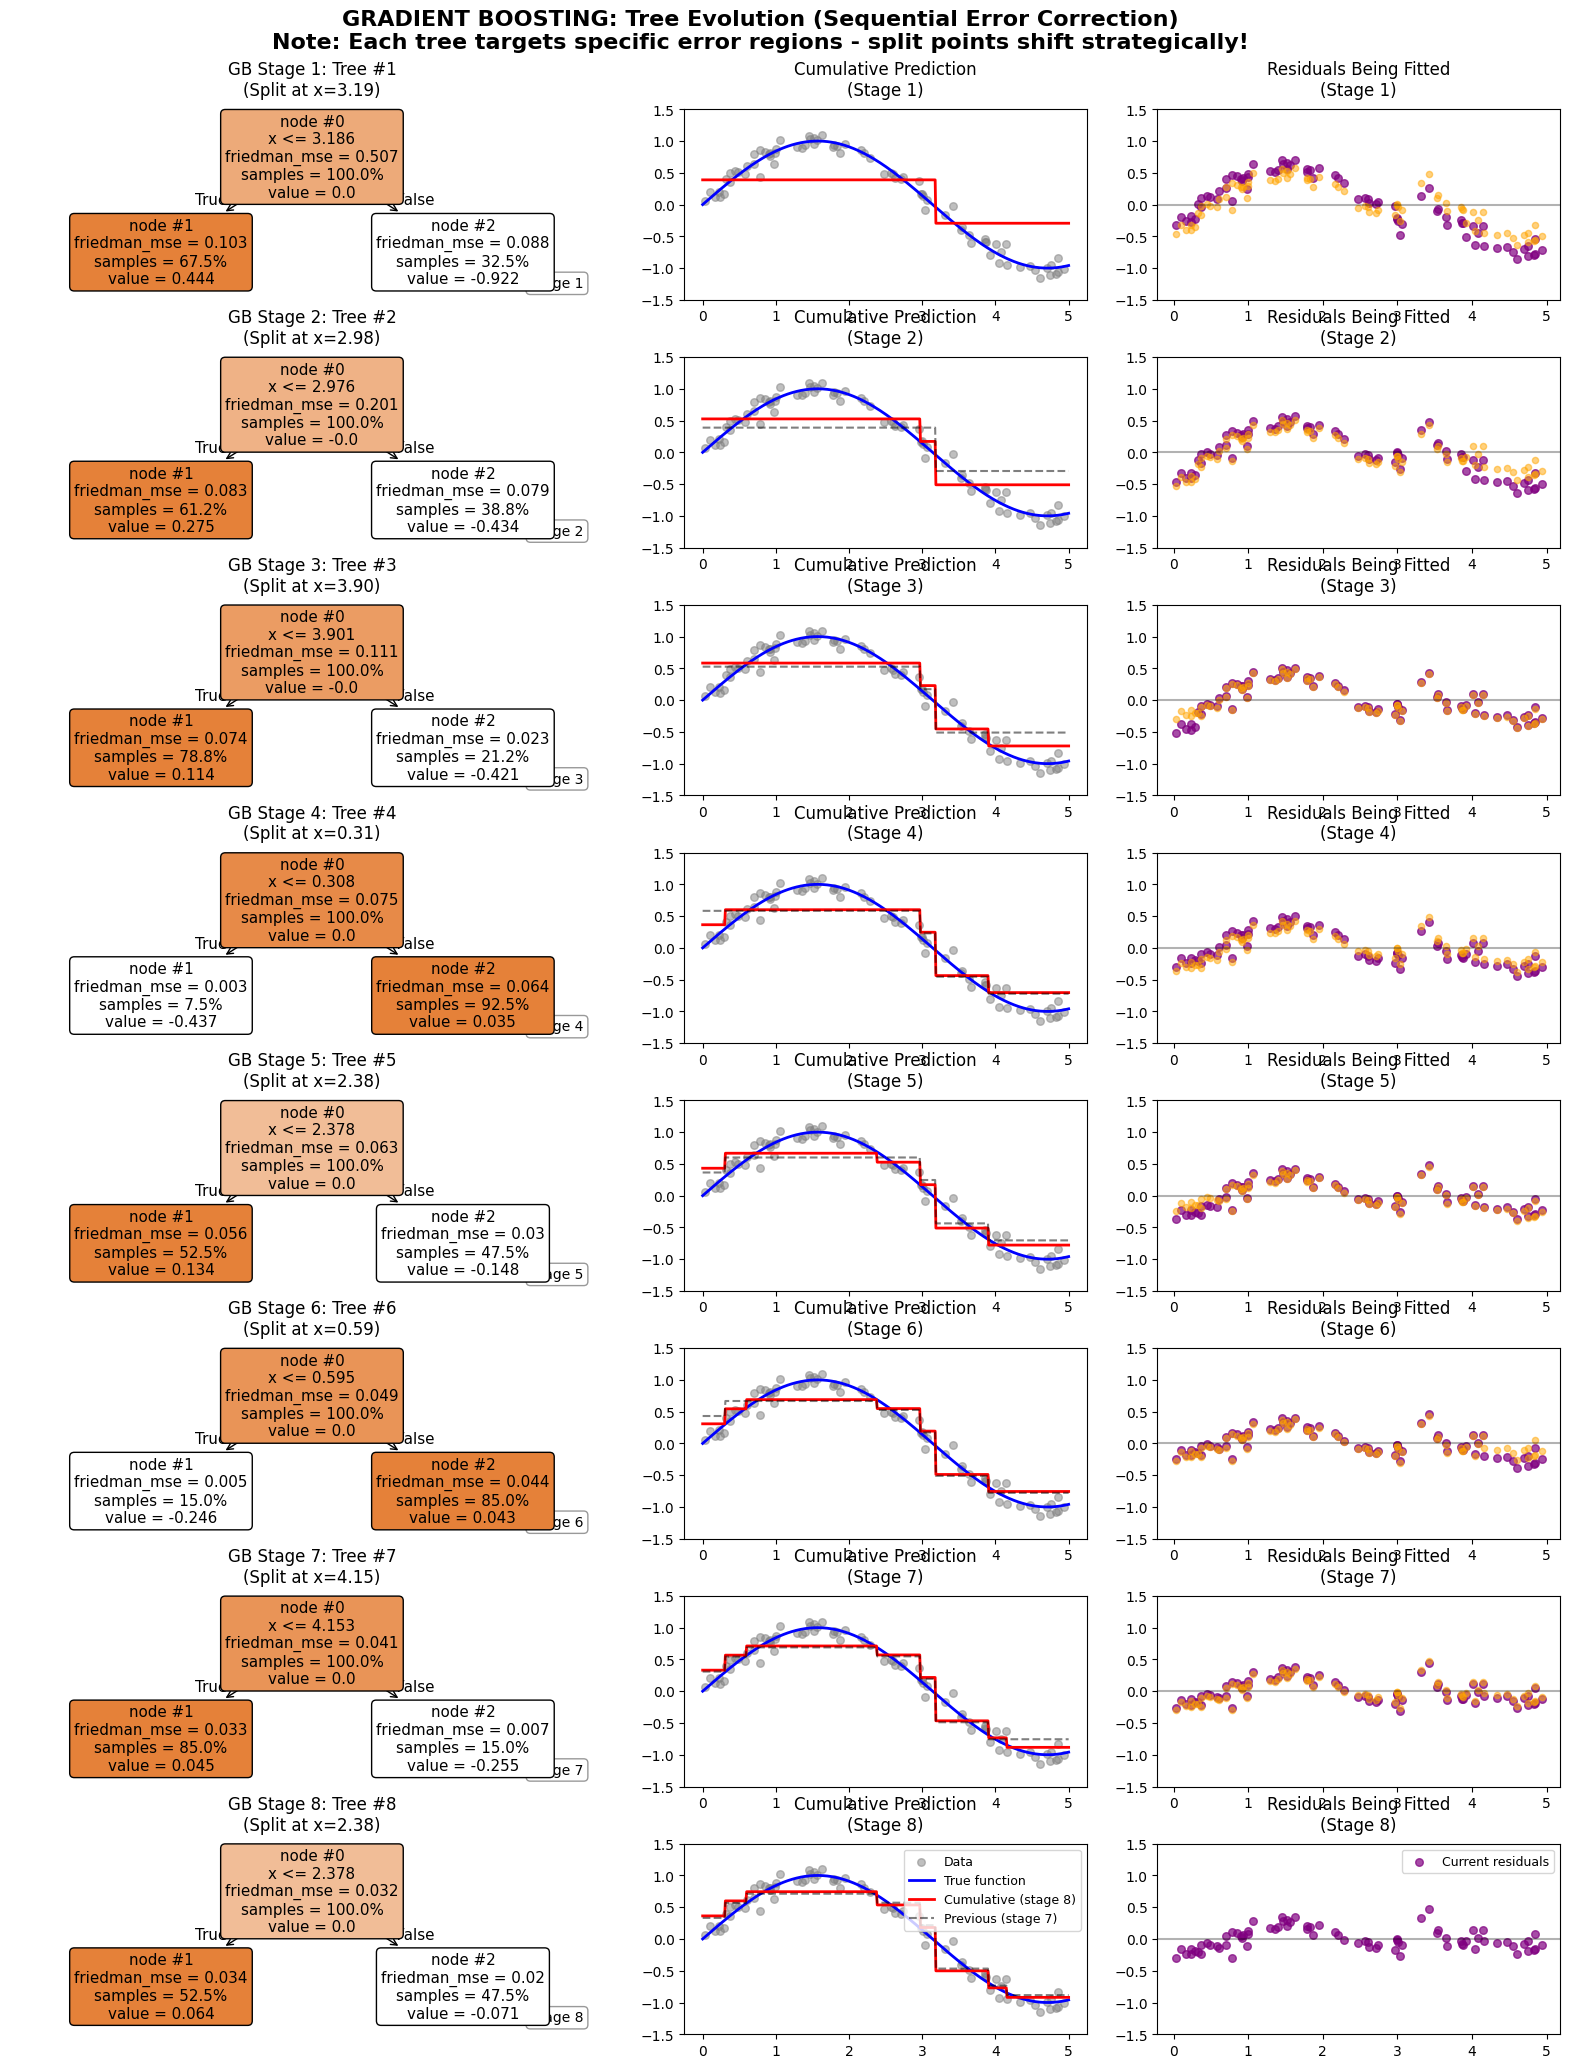

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import plot_tree
import matplotlib.gridspec as gridspec
import matplotlib as mpl

# Set up synthetic data (1D regression)
np.random.seed(42)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.randn(80) * 0.1
X_plot = np.linspace(0, 5, 500)[:, np.newaxis]

# ====== RANDOM FOREST: COMPREHENSIVE TREE EVOLUTION ======
def rf_tree_evolution():
    n_stages = 6
    stages = [1, 2, 3, 5, 10, 20]  # Number of trees at each stage

    # Create figure with gridspec for better layout control
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(n_stages, 2, width_ratios=[1.5, 1], wspace=0.1)

    rf_models = []

    # Train models for each stage
    for n_trees in stages:
        rf = RandomForestRegressor(n_estimators=n_trees,
                                  max_depth=2,
                                  random_state=42,
                                  bootstrap=True)
        rf.fit(X, y)
        rf_models.append(rf)

    # Plot all stages
    for i, (n_trees, rf) in enumerate(zip(stages, rf_models)):
        # Tree structure (first tree only)
        ax_tree = fig.add_subplot(gs[i, 0])
        plot_tree(rf.estimators_[0],
                 feature_names=['x'],
                 filled=True,
                 rounded=True,
                 proportion=True,
                 node_ids=True,
                 ax=ax_tree)
        ax_tree.set_title(f'Random Forest Stage {i+1}: First Tree (n={n_trees} trees)',
                         fontsize=12, pad=10)

        # Add stage label in the corner
        ax_tree.text(0.95, 0.05, f'Stage {i+1}',
                    transform=ax_tree.transAxes,
                    fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=dict(boxstyle="round,pad=0.3",
                             fc="white", ec="gray", alpha=0.8))

        # Prediction plot
        ax_pred = fig.add_subplot(gs[i, 1])
        ax_pred.scatter(X, y, color='gray', alpha=0.5, s=30, label='Data')
        ax_pred.plot(X_plot, np.sin(X_plot), 'b-', linewidth=2, label='True function')
        ax_pred.plot(X_plot, rf.predict(X_plot), 'r-', linewidth=2,
                    label=f'Ensemble (n={n_trees})')

        # Highlight first tree's prediction
        if n_trees > 1:
            ax_pred.plot(X_plot, rf.estimators_[0].predict(X_plot), 'g--', alpha=0.7,
                        label='First tree only')

        ax_pred.set_title(f'Prediction (n={n_trees} trees)', fontsize=12, pad=10)
        ax_pred.set_ylim(-1.5, 1.5)

        # Only add legend to last plot
        if i == n_stages - 1:
            ax_pred.legend(loc='upper right', fontsize=9)

    plt.suptitle('RANDOM FOREST: Tree Evolution (Trees Grow INDEPENDENTLY)\n'
                 'Note: First tree structure NEVER changes as more trees are added!',
                 fontsize=16, fontweight='bold', y=0.92)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('rf_tree_evolution_all.png', dpi=150, bbox_inches='tight')
    plt.show()

# ====== GRADIENT BOOSTING: COMPREHENSIVE TREE EVOLUTION ======
def gb_tree_evolution():
    n_stages = 8
    stages = [0, 1, 2, 3, 4, 5, 6, 7]  # Training stages (0-indexed)

    # Train model with enough estimators
    gb = GradientBoostingRegressor(n_estimators=max(stages)+1,
                                  max_depth=1,  # Stumps for clarity
                                  learning_rate=0.5,
                                  random_state=42)
    gb.fit(X, y)

    # Precompute staged predictions
    train_preds = []
    test_preds = []
    for p_train, p_test in zip(gb.staged_predict(X), gb.staged_predict(X_plot)):
        train_preds.append(p_train)
        test_preds.append(p_test)

    # Create figure with detailed gridspec
    fig = plt.figure(figsize=(20, 25))
    gs = gridspec.GridSpec(n_stages, 3, width_ratios=[1.5, 1, 1], wspace=0.15, hspace=0.3)

    # Plot all stages
    for i, stage in enumerate(stages):
        # Tree structure
        ax_tree = fig.add_subplot(gs[i, 0])
        plot_tree(gb.estimators_[stage][0],
                 feature_names=['x'],
                 filled=True,
                 rounded=True,
                 proportion=True,
                 node_ids=True,
                 ax=ax_tree)

        # Get split point
        split_point = gb.estimators_[stage][0].tree_.threshold[0]
        ax_tree.set_title(f'GB Stage {i+1}: Tree #{stage+1}\n(Split at x={split_point:.2f})',
                         fontsize=12, pad=10)

        # Add stage label
        ax_tree.text(0.95, 0.05, f'Stage {i+1}',
                    transform=ax_tree.transAxes,
                    fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=dict(boxstyle="round,pad=0.3",
                             fc="white", ec="gray", alpha=0.8))

        # Cumulative prediction
        ax_pred = fig.add_subplot(gs[i, 1])
        ax_pred.scatter(X, y, color='gray', alpha=0.5, s=30, label='Data')
        ax_pred.plot(X_plot, np.sin(X_plot), 'b-', linewidth=2, label='True function')
        ax_pred.plot(X_plot, test_preds[stage], 'r-', linewidth=2,
                    label=f'Cumulative (stage {stage+1})')

        # Show previous prediction for comparison
        if stage > 0:
            ax_pred.plot(X_plot, test_preds[stage-1], 'k--', alpha=0.5,
                        label=f'Previous (stage {stage})')

        ax_pred.set_title(f'Cumulative Prediction\n(Stage {stage+1})', fontsize=12, pad=10)
        ax_pred.set_ylim(-1.5, 1.5)

        # Residuals being fitted
        ax_res = fig.add_subplot(gs[i, 2])
        residuals = y - train_preds[stage]
        ax_res.scatter(X, residuals, color='purple', s=30, alpha=0.7,
                      label=f'Current residuals')

        # Show what the NEXT tree will fit (if not last stage)
        if stage < len(stages) - 1:
            next_residuals = y - train_preds[stage+1]
            ax_res.scatter(X, next_residuals, color='orange', s=20, alpha=0.5,
                          label='Next residuals')

        ax_res.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax_res.set_title(f'Residuals Being Fitted\n(Stage {stage+1})', fontsize=12, pad=10)
        ax_res.set_ylim(-1.5, 1.5)

        # Only add legend to last row
        if i == n_stages - 1:
            ax_pred.legend(loc='upper right', fontsize=9)
            ax_res.legend(loc='upper right', fontsize=9)

    plt.suptitle('GRADIENT BOOSTING: Tree Evolution (Sequential Error Correction)\n'
                 'Note: Each tree targets specific error regions - split points shift strategically!',
                 fontsize=16, fontweight='bold', y=0.92)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('gb_tree_evolution_all.png', dpi=150, bbox_inches='tight')
    plt.show()

# ====== RUN VISUALIZATIONS ======
print("="*60)
print("RANDOM FOREST: Trees grow INDEPENDENTLY (first tree never changes)")
print("="*60)
rf_tree_evolution()

print("\n" + "="*60)
print("GRADIENT BOOSTING: Trees grow SEQUENTIALLY (each fixes previous errors)")
print("="*60)
gb_tree_evolution()